# Classifying Partisan Bias in News Articles
- I am attempting to replicate some of the methods used in [Classifying Partisan Bias in News Articles:
 Leveraging an Understanding of Political Language
 and Article Structure](https://web.stanford.edu/class/archive/cs/cs224n/cs224n.1234/final-reports/final-report-169502805.pdf), which uses a dataset from a competition on detecting hyperpartisan and fake news.
- Dataset location [Data for PAN at SemEval 2019 Task 4: Hyperpartisan News Detection](https://zenodo.org/records/1489920)
- Also see [Hyperpartisan News Detection 2019](https://pan.webis.de/semeval19/semeval19-web/#data) and [SemEval-2019 Task 4: Hyperpartisan News Detection](https://aclanthology.org/S19-2145.pdf)


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time

import xgboost as xgb
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, TextVectorization
from tensorflow.keras.preprocessing import sequence

2025-08-22 18:33:29.036082: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def dataset_file_path(fname):
    return os.path.join(os.path.join(os.getcwd(), "dataset", fname))

#### Comments
 - The dataset is downloaded to, and prepared in, the `dataset` dir
 - `articles-validation-bypublisher-20181122-html-escaped.xml` contains a list of 150,000 news articles (sourced online)
 - `ground-truth-validation-bypublisher-20181122.xml` contains the targets for these articles
 - Targets are `left`, `left-center`, `least`, `right-center`, `right`

In [3]:
training_data_file = dataset_file_path("articles-validation-bypublisher-20181122-html-escaped.xml")
target_data_file = dataset_file_path("ground-truth-validation-bypublisher-20181122.xml")

In [4]:
datadf = pd.read_xml(path_or_buffer = training_data_file)
targetdf = pd.read_xml(path_or_buffer = target_data_file)
df = pd.concat([datadf, targetdf], axis = 1)
df.columns = [
    'id',
    'published-at',
    'title',
    'article',
    'id2',
    'hyperpartisan',
    'bias',
    'url',
    'labeled-by'
]

#### Comments
- Training data and targets are now in a single dataframe.
- There should be 150,000 articles
- The `id` field from training and target sets should match
- No record should have an empty `article` or `bias` field

In [5]:
# run some test cases to ensure the data is good
if len(df) == 150_000:
    print(f"PASS: dataframe has {len(df)} records as expected")
else:
    print(f"FAIL: dataframe has {len(df)} records - expected 150,000")

def validate_column_does_not_have_null_values(column_name):
    if df[column_name].isnull().sum() == 0:
        print(f"PASS: no null values detected for column '{column_name}'")
    else:
        print(f"FAIL: {df[column_name].isnull().sum()} null values for column '{column_name}' not expected")

validate_column_does_not_have_null_values("id")
validate_column_does_not_have_null_values("id2")
validate_column_does_not_have_null_values("article")
validate_column_does_not_have_null_values("bias")

id_matches = df['id'] == df['id2']
n_not_matched = id_matches.value_counts().get(False, 0)
n_matched = id_matches.value_counts().get(True, 0)
if n_matched == 150_000 and n_not_matched == 0:
    print(f"PASS: all article IDs from training file and target file matched (id == id2 for all records)")
else:
    print(f"FAIL: {n_matched} article IDs from training file matched, BUT {n_not_matched} article IDs did not match")

PASS: dataframe has 150000 records as expected
PASS: no null values detected for column 'id'
PASS: no null values detected for column 'id2'
PASS: no null values detected for column 'article'
PASS: no null values detected for column 'bias'
PASS: all article IDs from training file and target file matched (id == id2 for all records)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             150000 non-null  int64 
 1   published-at   100492 non-null  object
 2   title          137723 non-null  object
 3   article        150000 non-null  object
 4   id2            150000 non-null  int64 
 5   hyperpartisan  150000 non-null  bool  
 6   bias           150000 non-null  object
 7   url            150000 non-null  object
 8   labeled-by     150000 non-null  object
dtypes: bool(1), int64(2), object(6)
memory usage: 9.3+ MB


#### Comments
 - The `bias` column is the target
 - `hyperpartisan` column is related to `bias`
 - Let's inspect the range of values for `bias`, and how they map to `hyperpartisan`

In [7]:
hy_df = df.groupby(['hyperpartisan', 'bias'])['bias'].count()
h, b, c = [], [], []
for k,v in hy_df.items():
    h.append(k[0])
    b.append(k[1])
    c.append(v)

pd.options.display.max_rows = len(h)
display(pd.DataFrame({"hyperpartisan": h, "bias": b, "count": c}))

,hyperpartisan,bias,count
0,False,least,38296
1,False,left-center,23473
2,False,right-center,13231
3,True,left,37500
4,True,right,37500


### Comments
 - As expected, the hyperpartisan label corresponds to categories `left` and `right`
   - (less partisan articles are labeled `left-center`, `right-center`, or `least`)
 - I will focus on predicting `bias` and ignore the `hyperpartisan` column since it can be inferred from `bias`
 - The `id` and `id2` fields have served their purpose in validating the join. `id2` will be dropped while keeping `id` as a key into the original data
 - Additionally dropping fields `published-at`, `title`, `url`, and `labeled-by` that won't be used in this analysis (of course, `title` could contain useful information, but I will not be exploring that)
 - The `bias` field will be mapped to numerical values
 - **Half the dataset will be dropped** to reduce model training times

In [8]:
df = df.drop(['id2', 'hyperpartisan', 'published-at', 'title', 'url', 'labeled-by'], axis=1)

bias_mapping = {'left': 0, 'left-center': 1, 'least': 2, 'right-center': 3, 'right': 4 }
bias_mapping_reverse = dict((v,k) for k,v in bias_mapping.items())
df['bias'] = df['bias'].map(bias_mapping)

Using train_test_split to drop half the dataset, while preserving the representation across categories

In [9]:
# using train_test_split

df, _, _, _ = train_test_split(
    df,
    df['bias'],
    test_size=0.5,
    random_state=42,
    stratify=df['bias'])

df.reset_index(drop = True, inplace = True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       75000 non-null  int64 
 1   article  75000 non-null  object
 2   bias     75000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.7+ MB


AT THIS POINT DISPLAY ONE EXAMPLE OF EACH bias type

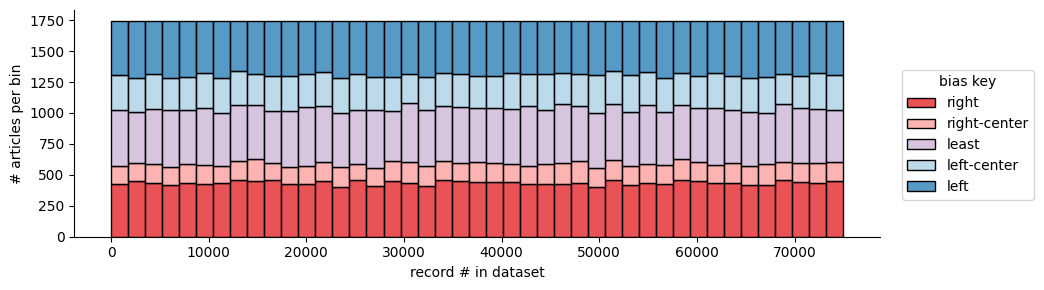

In [11]:
base_palette = sns.color_palette("Paired")
bias_palette = [
    base_palette[1], # blue (left)
    base_palette[0], # light blue (left-center)
    base_palette[8], # purple (least)
    base_palette[4], # light red (right-center)
    base_palette[5], # red (right)
]

data_distribution_chart = sns.displot(
    data = df,
    x = df.index,
    hue = "bias",
    multiple = "stack",
    height = 3,
    aspect = 3,
    hue_order = list(bias_mapping.values()),
    palette = bias_palette,
    legend = False
    # faced_kws = { "legend_data": bias_mapping_reverse }
)

data_distribution_chart.set_xlabels("record # in dataset")
data_distribution_chart.set_ylabels("# articles per bin")

ax = data_distribution_chart.axes[0, 0]
keys = list(bias_mapping.keys())
keys.reverse()
ax.legend(
    labels = keys,
    title = "bias key",
    loc = "center right",
    bbox_to_anchor=(0.7, 0.2, 0.5, 0.5)
)
plt.show()

#### Comments
 - The 5 categories are distributed roughly evenly across the dataset
 - The top (blue/`left`) and bottom (red/`right`) regions represent the `hyperpartisan` articles
 - Middle bands (light blue, light red, purple) are not considered hyperpartisan

#### Save this dataset to disk for convenience

In [12]:
df.to_pickle(dataset_file_path("articles_dataframe.pkl"))

# going forward the vectorized df can be loaded using:
# df = pd.read_pickle(os.path.join(os.getcwd(), "dataset", "articles_dataframe.pkl"))

In [13]:
# 80/20 test train split
x_train_raw, x_test_raw, y_train, y_test = train_test_split(df, df['bias'], test_size=0.2, random_state=42, stratify = df['bias'])

In [14]:
print(x_train_raw.shape)
print(x_test_raw.shape)
print(y_train.shape)
print(y_test.shape)

(60000, 3)
(15000, 3)
(60000,)
(15000,)


#### Run TF-IDF Vectorization and save to disk for convenience
- (Add some comments on why this choice was made, and what was done to arrive at it.)
- (Add comment about stop words customization)
- Add comment about using fit_transform on 80%
   - but only transform on 20% (we can't know future data, so cannot actually fit on it)

In [ ]:
additional_stopwords = ['amp', 'com', 'href', 'htm', 'html', 'http', 'https', 'php', 'searchindex', 'solr', 'www']
stop_words = list(text.ENGLISH_STOP_WORDS.union(additional_stopwords))

vectorizer = TfidfVectorizer(
    lowercase=False,
    stop_words=stop_words, 
    max_features=1000,
    min_df=5,
    max_df=0.7,
    ngram_range=(1,2))

In [17]:
bag_of_words = vectorizer.fit_transform(x_train_raw['article'])
x_train = pd.DataFrame(bag_of_words.toarray(), columns=vectorizer.get_feature_names_out())
x_train.to_pickle(dataset_file_path("articles_xtrain_tfidf_vectorized.pkl"))

bag_of_words_test = vectorizer.transform(x_test_raw['article'])
x_test = pd.DataFrame(bag_of_words_test.toarray(), columns=vectorizer.get_feature_names_out())
x_test.to_pickle(dataset_file_path("articles_xtest_tfidf_vectorized.pkl"))

y_train.to_pickle(dataset_file_path("targets_ytrain.pkl"))
y_test.to_pickle(dataset_file_path("targets_ytest.pkl"))

x_train_raw.to_pickle(dataset_file_path("articles_xtrain_raw.pkl"))
x_test_raw.to_pickle(dataset_file_path("articles_xtest_raw.pkl"))

# START FROM HERE FOR FUTURE ATTEMPTS

In [3]:
######### Add init_imports True/False, and run the imports if false. Re-initialize the directory variable
# Also, don't run this cell if init_imports is true

# TF-IDF Vectorized x_train and x_test
x_train = pd.read_pickle(dataset_file_path("articles_xtrain_tfidf_vectorized.pkl"))
x_test = pd.read_pickle(dataset_file_path("articles_xtest_tfidf_vectorized.pkl"))

# Targets
y_train = pd.read_pickle(dataset_file_path("targets_ytrain.pkl"))
y_test = pd.read_pickle(dataset_file_path("targets_ytest.pkl"))

# Non-vectorized training and test data
x_train_raw = pd.read_pickle(dataset_file_path("articles_xtrain_raw.pkl"))
x_test_raw = pd.read_pickle(dataset_file_path("articles_xtest_raw.pkl"))

#### Determining the feature size for training
 - The articles must be vectorized for model training. The plan is to use TF-IDF
 - Optimum values for max_features (and other params) can be found using GridSearchCV, with Logistic Regression
 - I'll assume the optimum choice for Logistic Regression is good enough for other classifiers, and use that option going forward
 - Will use scikit's default stopwords list, even though it has [known issues](https://aclanthology.org/W18-2502/)
 - Update: **GridSearchCV with a Pipeline was crashing the kernel!** Working around it with a manual grid search

## Classification Using Logistic Regression

In [3]:
cv_max_features = [1000, 2500]
cv_ngram_upper_range = [1, 2]

# fetch cartesian product of feature ranges for grid search
from itertools import product
cv_params = list(product(cv_max_features, cv_ngram_upper_range))

cv_result = []
for max_features, ngram_upper_range in cv_params:

    vectorizer = TfidfVectorizer(
        lowercase=True,
        stop_words=stop_words, 
        max_features=max_features,
        min_df=5,
        max_df=0.7,
        ngram_range=(1,ngram_upper_range))

    vec_time = time.time()
    bag_of_words = vectorizer.fit_transform(df['article'])
    vec_time = time.time() - vec_time
    print(f"vec_time {vec_time:.3f}")

    bag_of_words_df = pd.DataFrame(
        bag_of_words.toarray(), 
        columns=vectorizer.get_feature_names_out())
    x_train, x_test, y_train, y_test = train_test_split(bag_of_words_df, 
                                                    df['bias'], 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=df['bias'])

    logregmodel = LogisticRegression(max_iter=200, random_state=42, solver='lbfgs')
    model_time = time.time()
    logregmodel.fit(x_train, y_train)
    model_time = time.time() - model_time
    model_score = logregmodel.score(x_test, y_test)

    cv_result.append([model_score, max_features, ngram_upper_range, vec_time, model_time])
    print(f"model_time {model_time:.3f}")
    print(f"model_score {model_score:.3f}")

cv_df = pd.DataFrame(
    cv_result,
    columns = ['model_score', 'max_features', 'ngram_upper_range', 'vectorizer_time', 'train_time'])
pd.options.display.float_format = "{:,.2f}".format
pd.options.display.max_rows = len(cv_result)
display(cv_df)

df already loaded.. not loading again
vec_time 61.660
model_time 26.383
model_score 0.736
vec_time 294.970
model_time 30.631
model_score 0.742
vec_time 61.191
model_time 70.592
model_score 0.786
vec_time 297.467
model_time 94.300
model_score 0.790


,model_score,max_features,ngram_upper_range,vectorizer_time,train_time
0,0.74,1000,1,61.66,26.38
1,0.74,1000,2,294.97,30.63
2,0.79,2500,1,61.19,70.59
3,0.79,2500,2,297.47,94.30


#### Comments
- Best performance is with `2500` features, and ngram range `(1,2)` (single words and bigrams)
- **However** performance with `1000` features, and ngram range `(1,2)` is very similar, albiet with *significantly lower* training time, which will add up over grid searches for other models as well -- therefore, I will vectorize with 1000 features and single words + bigrams for all model training going forward.
- Previous testing showed `lbfgs` solver vs. `sag` does not have a tangible impact on accuracy. Proceeding with `lbfgs` due to the significantly lower training time.
- Previous testing showed min_df, max_df values did not have much impact or enable reducing feature size. Tuning that has been eliminated from the grid search to scope the search.

Next step: create a dataframe of TF-IDF vectorized articles with these params, and save to disk for quick retreival for subsequent use

In [5]:
print(bag_of_words_df.info())
bag_of_words_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Columns: 1000 entries, 000 to young
dtypes: float64(1000)
memory usage: 1.1 GB
None


,000,01,02,03,04,05,06,07,08,09,...,wrong,wrote,www,www nytimes,www washingtonpost,year,year old,years,years ago,young
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00
1,0.11,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.31,0.06,0.00,0.00,0.08,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,0.00,0.00,0.00,0.00,0.00,0.07,0.07,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.08,0.00,0.02,0.00,0.03


## Classification Using Logistic Regression

In [ ]:
cv_grid = GridSearchCV(
    LogisticRegression(
        max_iter=1000,
        random_state=42),
    param_grid = {
        #'solver': ['lbfgs', 'sag'],
        #'penalty': ['l2', None]
        'solver': ['sag'],
        'penalty': [None]
    },
    verbose = 3,
    n_jobs = 1)

cv_grid.fit(x_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/adhavle/ml/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ..........penalty=None, solver=sag;, score=0.707 total time= 9.8min


In [7]:
print(cv_grid.best_params_)
lr_model = cv_grid.best_estimator_
lr_model.score(x_test, y_test)

{'max_iter': 50, 'penalty': 'l2', 'solver': 'sag'}


0.7222

In [9]:
cv_grid.cv_results_

{'mean_fit_time': array([ 3.54386387, 25.99917412,  3.80047035, 29.75404906,  6.88946428,
        26.78611789,  7.53589029, 59.59981947]),
 'std_fit_time': array([0.08906488, 2.52083829, 0.23495191, 0.43113253, 0.3787754 ,
        3.35929531, 0.42201975, 0.41775001]),
 'mean_score_time': array([0.01707573, 0.01514001, 0.01719351, 0.01650887, 0.01700263,
        0.01558599, 0.01722741, 0.01524653]),
 'std_score_time': array([0.00074585, 0.00085672, 0.00064946, 0.00270427, 0.00038458,
        0.00273567, 0.00074864, 0.00090061]),
 'param_max_iter': masked_array(data=[50, 50, 50, 50, 100, 100, 100, 100],
              mask=[False, False, False, False, False, False, False, False],
        fill_value=999999),
 'param_penalty': masked_array(data=['l2', 'l2', None, None, 'l2', 'l2', None, None],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_solver': masked_array(data=['lbfgs', 'sag', 'lbfgs', 'sag', 'lb

## Classification Using XGBoost

In [ ]:
cv_grid = GridSearchCV(
    XGBClassifier(
        num_class=5,
        eval_metric='mlogloss',
        device="cuda",
        random_state=42),
    param_grid = {
        'max_depth': [5, 6],
        'learning_rate': [0.3, 0.4],
        'n_estimators': [50, 100]
    },
    verbose = 3,
    n_jobs = 1)

cv_grid.fit(x_train, y_train)

In [13]:
print(cv_grid.best_params_)
xgb_model = cv_grid.best_estimator_
xgb_model.score(x_test, y_test)

{'learning_rate': 0.4, 'max_depth': 6, 'n_estimators': 100}


0.8044666666666667

## Classification Using CNN

In [4]:
### Similarly prepare word-index vectorization for TF, for later. Doing this now because later in the notebook it causes OOM errors on 60k rows. Therefore doing it now and saving, and then loading from disk later
# - (add note on how choices were made)
# - (add note on deprecation of vectorizor method
# - output_mode = int since the order of words in the text changes their context. Will use an Embedding layer for blah de blah.. why is the embedding layer important here? What does it do????
# MOVE ABOVE TO A MARKDOWN CELL

VOCAB_SIZE = 20000
MAX_SEQUENCE_LENGTH = 1000
# TRAIN_SET_SIZE = 60000

int_vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH)

# Hits OOM error with set size = 120000
# Solution is to stream the records using a TFRecordDataset as described here https://www.tensorflow.org/tutorials/load_data/tfrecord
# However, I'll reduce the size of the training set instead.
int_vectorize_layer.adapt(x_train_raw['article'])

I0000 00:00:1755912828.708346   28159 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3590 MB memory:  -> device: 0, name: NVIDIA RTX A2000, pci bus id: 0000:03:00.0, compute capability: 8.6


In [5]:
# int_vectorize_layer.get_vocabulary()
x_train_tf = int_vectorize_layer(x_train_raw['article'])
x_test_tf = int_vectorize_layer(x_test_raw['article'])
y_train_tf = tf.keras.utils.to_categorical(y_train)
y_test_tf = tf.keras.utils.to_categorical(y_test)

In [6]:
model = Sequential([
    Embedding(VOCAB_SIZE, MAX_SEQUENCE_LENGTH),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [7]:
model.fit(x_train_tf, y_train_tf, batch_size=32, epochs=15, validation_split=0.2)

Epoch 1/15


2025-08-22 18:34:36.808676: I external/local_xla/xla/service/service.cc:163] XLA service 0x717280004970 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-08-22 18:34:36.808728: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA RTX A2000, Compute Capability 8.6
2025-08-22 18:34:36.864530: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-08-22 18:34:37.062600: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91200
2025-08-22 18:34:37.183320: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-08-22 18:34:37.184017: I external

   3/1500 ━━━━━━━━━━━━━━━━━━━━ 1:33 62ms/step - accuracy: 0.1267 - loss: 1.6632

I0000 00:00:1755912882.772485   28371 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 58s 33ms/step - accuracy: 0.7460 - loss: 0.6605 - val_accuracy: 0.8503 - val_loss: 0.4040
Epoch 2/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 48s 32ms/step - accuracy: 0.8894 - loss: 0.3191 - val_accuracy: 0.8716 - val_loss: 0.3699
Epoch 3/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 50s 33ms/step - accuracy: 0.9427 - loss: 0.1688 - val_accuracy: 0.8737 - val_loss: 0.4181
Epoch 4/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 50s 33ms/step - accuracy: 0.9685 - loss: 0.0925 - val_accuracy: 0.8702 - val_loss: 0.5196
Epoch 5/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 51s 34ms/step - accuracy: 0.9763 - loss: 0.0716 - val_accuracy: 0.8731 - val_loss: 0.5291
Epoch 6/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 50s 34ms/step - accuracy: 0.9802 - loss: 0.0613 - val_accuracy: 0.8741 - val_loss: 0.6040
Epoch 7/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 51s 34ms/step - accuracy: 0.9825 - loss: 0.0524 - val_accuracy: 0.8685 - val_loss: 0.6822
Epoch 8/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 50s 34ms/step - accuracy: 0.9865 - loss: 0.04

In [9]:
tf_test_loss, tf_test_accuracy = model.evaluate(x_test_tf, y_test_tf)
print(f"TF CNN Test Accuracy: {tf_test_accuracy:.4f}")

469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8705 - loss: 0.9456
TF CNN Test Accuracy: 0.8705


In [10]:
# Add visuals (accuracy vs. loss graph)
# Add saving for best model (via callback)